In [2]:
import pandas as pd
import shutil
import numpy as np
import skbio
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
from matplotlib import rcParams
#from statsmodels.stats.multicomp import pairwise_tukeyhsd
#from statsmodels.stats.multicomp import MultiComparison
#dunns
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.libqsturng import psturng
import warnings

import plotly.express as px
import plotly.graph_objects as go
import os
import re
from plotly.subplots import make_subplots

from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
import statsmodels.api as sm

import statsmodels.api as sa
import scikit_posthocs as sp

from pingouin import kruskal

from statannot import add_stat_annotation

rcParams.update({'figure.autolayout': True})

In [3]:
# date1 = '11.3.21'
# date2 = '18.3.21'
# finaldate = '11.3.21+18.3.21'

In [4]:
# if not os.path.exists(f'../../../../data/plots/luminescence/{finaldate}'):
#     os.mkdir(f'../../../../data/plots/luminescence/{finaldate}')

In [5]:
# if not os.path.exists(f'../../../../data/luminescence/to_be_sorted/{finaldate}'):
#     os.mkdir(f'../../../../data/luminescence/to_be_sorted/{finaldate}')

/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.7, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [6]:
# #copy files to new folder
# src1 = f'../../../../data/luminescence/to_be_sorted/{date1}/output_raw.csv'
# dst1 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date1}.csv'
# src2 = f'../../../../data/luminescence/to_be_sorted/{date2}/output_raw.csv'
# dst2 = f'../../../../data/luminescence/to_be_sorted/{finaldate}/output_raw_{date2}.csv'
# shutil.copyfile(src1,dst1)
# shutil.copyfile(src2,dst2)

In [7]:
def add_promoter_column(df,promoter_number,promoter):
    df.loc[df.name.str.match(fr'(^{promoter_number}.*)')==True, 'Promoter'] = promoter
    

In [8]:
#add TF coexpression column
def add_tf_column(df, TF_number, TF):
    """function to add TF added column based on an input df, a TF_number and a TF name"""
    df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.isnull()==True, 'TF_added'] = TF
    for index, value in df.loc[df.name.str.contains(fr'.*{TF_number}.*')&df.TF_added.notnull()].TF_added.items():
        if re.match(fr'.*{TF}.*', value):
            pass
        else:
            df.iloc[index, df.columns.get_loc('TF_added')] = f'{value}+{TF}'


In [9]:
# #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
# def batch_correction(df,calibrator_promoter_name):
#    #print(df[df.Promoter==calibrator_promoter_name])
#     calibrator = df[df.Promoter==calibrator_promoter_name]
#     calibrator_mean = calibrator['nluc/fluc'].mean(axis=0)
#     df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [10]:
def batch_correction(df,calibrator_promoter_name):
   #print(df[df.Promoter==calibrator_promoter_name])
    calibrator = df[df.Promoter==calibrator_promoter_name]
    #exclude the NAA condition
    calibrator_no_NAA = calibrator[calibrator.condition=='nitrogen']
    #exclude added TFs or YFP
    calibrator_no_TFs = calibrator_no_NAA[calibrator_no_NAA.TF_added=='No TF']
    calibrator_mean = calibrator_no_TFs['nluc/fluc'].mean(axis=0)
    df['corrected_luminescence'] = df['nluc/fluc']/calibrator_mean*100 

In [50]:
def combine_plates(plate_dict, date):
    """combine the dfs of the plates in the plate dict"""
    for plate_number,plate_df in plate_dict.items():
        #define plate location
        file_location = f'../../../../data/luminescence/to_be_sorted/{date}/plate{plate_number}_output_raw.csv'
        #read in the plate
        plate_df = pd.read_csv(file_location, header=0)
        #add promoters to plate df
        add_promoter_column(plate_df, '14', 'ANAC032')
        add_promoter_column(plate_df, '16', 'ANR1')
        add_promoter_column(plate_df, '18', 'ARF18')
        add_promoter_column(plate_df, '20', 'NLP6')
        add_promoter_column(plate_df, '22', 'DREB26')
        add_promoter_column(plate_df, '24', 'NLP7')
        add_promoter_column(plate_df, '25', 'NIR1')
        add_promoter_column(plate_df, '35', 'NOS')
        add_promoter_column(plate_df, '36', 'STAP4')
        add_promoter_column(plate_df, '70', '35s')
        add_promoter_column(plate_df, '102', 'minimal_STAP4')
        add_promoter_column(plate_df, '103', '1xANR1')
        add_promoter_column(plate_df, '104', '1xNLP7')
        add_promoter_column(plate_df, '105', '1xTCP20+NLP7')
        add_promoter_column(plate_df, '106', '4xANR1')
        add_promoter_column(plate_df, '107', '4xNLP7')
        add_promoter_column(plate_df, '108', '4xTCP20+NLP7')
        add_promoter_column(plate_df, '109', '4xNRE')
        add_promoter_column(plate_df, '71', 'UBQ10')
        add_promoter_column(plate_df, '372', '4x[NRE-TATA]')
        add_promoter_column(plate_df, '373', '4x[NRE-TATA]+spacing')
        add_promoter_column(plate_df, '374', '4x[NRE-random]')
        add_promoter_column(plate_df, '375', '4x[NRE-random]+spacing')
        add_promoter_column(plate_df, '376', '3xHHO2-minsyn_105')
        add_promoter_column(plate_df, '377', 'minsyn_105-3xHHO2')
        add_promoter_column(plate_df, '378', '4x[bZIP3-random]')
        add_promoter_column(plate_df, '379', '4x[TGA1-random]')
        add_promoter_column(plate_df, '380', '2x[bZIP3-random-NRE-random]')
        add_promoter_column(plate_df, '381', '2x[TGA1-random-NRE-random]')

        #add TF column to date1 df
        plate_df['TF_added'] = np.nan
        add_tf_column(plate_df,'27','NLP6')
        add_tf_column(plate_df,'29','NLP7')
        add_tf_column(plate_df,'30','DREB26')
        add_tf_column(plate_df,'31','ANAC032')
        add_tf_column(plate_df,'32','ARF18')
        add_tf_column(plate_df,'33','ANR1')
        add_tf_column(plate_df,'111','TCP20')
        add_tf_column(plate_df,'348','HHO2')
        add_tf_column(plate_df,'349','bZIP3')
        add_tf_column(plate_df,'351','TGA1')
        add_tf_column(plate_df,'113','ARF9')
        add_tf_column(plate_df,'YFP','YFP')


        #Change TF_added NaN values to none
        plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF'

        #Change condition NaN values to nitrogen
        plate_df.loc[plate_df.condition.isnull()==True, 'condition'] = 'nitrogen'

        #add plate df to dictionary
        plate_dict[plate_number] = plate_df
        
        #divide by NOS calibrator (mean nos-LucN/35SLucF luminescence)
        batch_correction(plate_df, 'NOS')
        #Change TF_added NaN values to none
        plate_df.loc[plate_df.TF_added.isnull()==True, 'TF_added'] = 'No TF'
        #if NAA condition, add that name to the TF name
        plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'),'TF_added' ] = plate_df.loc[plate_df['condition'].str.contains('1uM_auxin'), 'TF_added'] + '_1μM_NAA'

    #merge the dfs with different dates
    #luminescence_raw_df = pd.concat(plate_dict.values(), ignore_index=True)
    luminescence_raw_df_plate1 = plate_dict[1]
    luminescence_raw_df_plate2 = plate_dict[2]
    # #Change TF_added NaN values to none
    # luminescence_raw_df_plate1.loc[luminescence_raw_df_plate1.TF_added.isnull()==True, 'TF_added'] = 'No TF'
    # luminescence_raw_df_plate2.loc[luminescence_raw_df_plate2.TF_added.isnull()==True, 'TF_added'] = 'No TF'

    
    

    #sort rows by the custom promoter order I want so plots are in the correct order
    #sort rows by the custom promoter order I want so plots are in the correct order
    luminescence_raw_df_plate1.Promoter = pd.Categorical(luminescence_raw_df_plate1.Promoter,
                                              ['YFP','NOS','minimal_STAP4','UBQ10','4xNRE','4x[NRE-TATA]','4x[NRE-TATA]+spacing','4x[NRE-random]','4x[NRE-random]+spacing','3xHHO2-minsyn_105','minsyn_105-3xHHO2','4x[bZIP3-random]','2x[bZIP3-random-NRE-random]','4x[TGA1-random]','2x[TGA1-random-NRE-random]'])
    luminescence_raw_df_plate1 = luminescence_raw_df_plate1.sort_values("Promoter")

    luminescence_raw_df_plate2.Promoter = pd.Categorical(luminescence_raw_df_plate2.Promoter,
                                              ['YFP','NOS','STAP4','35s','ANAC032','ANR1','ARF18','DREB26','NIR1','NLP6', 'NLP7'])
    luminescence_raw_df_plate2 = luminescence_raw_df_plate2.sort_values("Promoter")

    
    #save as file
    location1 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate1.tsv'
    location2 = f'../../../../data/luminescence/to_be_sorted/{date}/output_plate2.tsv'

    luminescence_raw_df_plate1.to_csv(location1,sep='\t',header=True)
    luminescence_raw_df_plate2.to_csv(location2,sep='\t',header=True)
    
    return luminescence_raw_df_plate1,luminescence_raw_df_plate2

In [51]:
# #first creat a dict of plate numbers and plate dfs
# #first create empty variables
luminescence_raw_df_plate1 = ""
luminescence_raw_df_plate2 = ""
# luminescence_raw_df_plate3 = ""
# luminescence_raw_df_plate4 = ""
# plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2, 3:luminescence_raw_df_plate3, 4:luminescence_raw_df_plate4}
plate_dict = {1:luminescence_raw_df_plate1, 2:luminescence_raw_df_plate2}

In [52]:
#combine plates
date = '27.9.21'
luminescence_raw_df_plate1,luminescence_raw_df_plate2 = combine_plates(plate_dict, date)

In [53]:
luminescence_raw_df_plate1

,well,content,fluc_luminescence,nluc_luminescence,well_row,well_col,name,condition,nluc/fluc,date,Promoter,TF_added,corrected_luminescence
71,F12,Sample X90,3131705.0,105871974.0,F,12,35+34,nitrogen,33.806496,27.9.21,NOS,No TF,100.897999
70,F11,Sample X84,2959224.0,102174198.0,F,11,35+34,nitrogen,34.527362,27.9.21,NOS,No TF,103.049475
69,F10,Sample X78,3071531.0,98851055.0,F,10,35+34,nitrogen,32.182991,27.9.21,NOS,No TF,96.052526
0,A01,Sample X1,139812.0,185114.0,A,1,102+YFP+34,nitrogen,1.324021,27.9.21,minimal_STAP4,YFP,3.951638
1,A02,Sample X9,136206.0,180742.0,A,2,102+YFP+34,nitrogen,1.326975,27.9.21,minimal_STAP4,YFP,3.960456
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,B11,Sample X80,368630.0,408572.0,B,11,92+34,nitrogen,1.108353,27.9.21,NaN,No TF,3.307960
23,B12,Sample X86,362450.0,407343.0,B,12,92+34,nitrogen,1.123860,27.9.21,NaN,No TF,3.354243
33,C10,Sample X75,255293.0,948819.0,C,10,92+29+34,nitrogen,3.716588,27.9.21,NaN,NLP7,11.092434
34,C11,Sample X81,231169.0,889855.0,C,11,92+29+34,nitrogen,3.849370,27.9.21,NaN,NLP7,11.488730


In [54]:
# luminescence_raw_df_renamed = luminescence_raw_df.copy()
# luminescence_raw_df_renamed.gene_type.replace('DREB26+ARF18','+DREB26+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('ARF18','+ARF18', inplace=True)
# luminescence_raw_df_renamed.gene_type.replace('randCont','random', inplace=True)


In [55]:
#get TF names
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names = luminescence_raw_df_plate1.TF_added.unique()
#Change TF names to +TF
luminescence_raw_df_plate1_renamed = luminescence_raw_df_plate1.copy()
for TF in names:
    if TF != 'No TF':
        luminescence_raw_df_plate1_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
luminescence_raw_df_plate1 = luminescence_raw_df_plate1_renamed

In [56]:
#get TF names
pd.Categorical(luminescence_raw_df_plate2.TF_added)
names = luminescence_raw_df_plate2.TF_added.unique()
#Change TF names to +TF
luminescence_raw_df_plate2_renamed = luminescence_raw_df_plate2.copy()
for TF in names:
    if TF != 'No TF':
        luminescence_raw_df_plate2_renamed.TF_added.replace(TF,f'+{TF}', inplace=True)
luminescence_raw_df_plate2 = luminescence_raw_df_plate2_renamed

### get names of each TF_added for later

In [57]:
pd.Categorical(luminescence_raw_df_plate1.TF_added)
names_plate1 = luminescence_raw_df_plate1.TF_added.unique()
for name in names_plate1:
    print(name)

No TF
+YFP
+NLP7
+HHO2
+bZIP3
+NLP7+bZIP3
+TGA1
+NLP7+TGA1


In [58]:
pd.Categorical(luminescence_raw_df_plate2.TF_added)
names_plate2 = luminescence_raw_df_plate2.TF_added.unique()
for name in names_plate2:
    print(name)

+YFP_1μM_NAA
No TF
+NLP6
+HHO2
+DREB26
+bZIP3
+ARF18
+TGA1
+ARF9
+ANR1
+No TF_1μM_NAA
+NLP7
+YFP
+ANAC032


In [59]:
#get list of promoters
pd.Categorical(luminescence_raw_df_plate1.Promoter)
prom_names_plate1 = luminescence_raw_df_plate1.Promoter.unique()
for name in prom_names_plate1:
    print(name)

NOS
minimal_STAP4
4xNRE
4x[NRE-TATA]
4x[NRE-TATA]+spacing
4x[NRE-random]
4x[NRE-random]+spacing
3xHHO2-minsyn_105
minsyn_105-3xHHO2
4x[bZIP3-random]
2x[bZIP3-random-NRE-random]
4x[TGA1-random]
2x[TGA1-random-NRE-random]
nan


In [60]:
#get list of promoters
pd.Categorical(luminescence_raw_df_plate2.Promoter)
prom_names_plate2 = luminescence_raw_df_plate2.Promoter.unique()
for name in prom_names_plate2:
    print(name)

NOS
35s


In [61]:
#create colours
from random import randint
color_plate1 = []
n_plate1 = len(prom_names_plate1)
for i in range(n_plate1):
    color_plate1.append('#%06X' % randint(0, 0xFFFFFF))
print(color_plate1)


['#75E9BF', '#221636', '#48EA37', '#CF9997', '#3258CE', '#B218AB', '#02699C', '#6C0716', '#99F3FA', '#2B4027', '#951C03', '#9F6CE6', '#C64CE1', '#645497']


In [62]:
#create colours
from random import randint
color_plate2 = []
n_plate2 = len(prom_names_plate2)
for i in range(n_plate1):
    color_plate2.append('#%06X' % randint(0, 0xFFFFFF))
print(color_plate2)


['#DFF43C', '#FEC1B7', '#F1E2CE', '#5B271D', '#602C4C', '#DF1055', '#B86D90', '#62C950', '#67ABAF', '#632604', '#C49170', '#D52236', '#309A8B', '#259605']


In [63]:
#make dictionary with TF_added names as key and the randomly generated colors as values
new_color_plate1 = dict(zip(names, color_plate1))
new_color_plate1

{'YFP_1μM_NAA': '#75E9BF',
 'No TF': '#221636',
 'NLP6': '#48EA37',
 'HHO2': '#CF9997',
 'DREB26': '#3258CE',
 'bZIP3': '#B218AB',
 'ARF18': '#02699C',
 'TGA1': '#6C0716',
 'ARF9': '#99F3FA',
 'ANR1': '#2B4027',
 'No TF_1μM_NAA': '#951C03',
 'NLP7': '#9F6CE6',
 'YFP': '#C64CE1',
 'ANAC032': '#645497'}

In [64]:
#make dictionary with TF_added names as key and the randomly generated colors as values
new_color_plate2 = dict(zip(names, color_plate2))
new_color_plate2

{'YFP_1μM_NAA': '#DFF43C',
 'No TF': '#FEC1B7',
 'NLP6': '#F1E2CE',
 'HHO2': '#5B271D',
 'DREB26': '#602C4C',
 'bZIP3': '#DF1055',
 'ARF18': '#B86D90',
 'TGA1': '#62C950',
 'ARF9': '#67ABAF',
 'ANR1': '#632604',
 'No TF_1μM_NAA': '#C49170',
 'NLP7': '#D52236',
 'YFP': '#309A8B',
 'ANAC032': '#259605'}

In [65]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}


# for prom in prom_names:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df[luminescence_raw_df.Promoter == prom].sort_values("TF_added", ascending=False)


#         fig = px.violin(df, x='TF_added',
#                                   y='corrected_luminescence', box=True,                       
#                                 color='TF_added', color_discrete_map=new_color,violinmode='overlay') #points="all"

#         fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#         fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#         fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#         #hide legend
#         fig.layout.update(showlegend=False)
#         #write to file static image and interactive one
#         fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         fig.show()

In [66]:
for TF in names_plate1:
    print(TF)

No TF
+YFP
+NLP7
+HHO2
+bZIP3
+NLP7+bZIP3
+TGA1
+NLP7+TGA1


In [67]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# fig = go.Figure(go.Violin(y=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].corrected_luminescence, x=luminescence_raw_df[luminescence_raw_df.Promoter == 'ANR1'].TF_added,
#                           fillcolor='#840122', box_visible=True, meanline_visible=True))
#               #points="all"

# fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)')
# fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
# fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
# #write to file static image and interactive one
# #fig.write_image(f'../../../../data/plots/luminescence/{date}/violin23.9.19.pdf')
# #fig.write_html(f'../../../../data/plots/luminescence/{date}/violin23.9.19.html')

# fig.show()

In [68]:
def dunn_posthoc_test(df, dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(
        df,
        val_col=dependent_variable,
        group_col=between,
        p_adjust="bonferroni",
    )

In [69]:
#create plot folder name
#make directory for the plots to be exported to
dirName = f'../../../../data/plots/luminescence/{date}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../../data/plots/luminescence/27.9.21  already exists


all pvalues={}
all pvalues={('+YFP', '+NLP7'): 0.0009312679298012023}
all pvalues={('+YFP', '+NLP7'): 0.000385819952450545}
all pvalues={('+YFP', '+NLP7'): 7.219008956342944e-05}
all pvalues={('+YFP', '+NLP7'): 1.0867896518082423e-08}
all pvalues={('+YFP', '+NLP7'): 0.0003384092152002691}
all pvalues={('+YFP', '+HHO2'): 0.000544388473831548}
all pvalues={('+YFP', '+HHO2'): 8.763281552806483e-05}
all pvalues={('+YFP', '+bZIP3'): 5.204670175177836e-06}
all pvalues={('+YFP', '+bZIP3'): 0.0217349647462711, ('+YFP', '+NLP7'): 2.2247528959578544e-05}
2x[bZIP3-random-NRE-random]
['+YFP', '+bZIP3', '+NLP7']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+YFP v.s. +bZIP3: Custom statistical test, P_val:2.173e-02
+YFP v.s. +NLP7: Custom statistical test, P_val:2.225e-05
all pvalues={('+YFP', '+TGA1'): 0.0003972371366940019}
all pvalues={('+YFP', '+NLP7'): 3.816748785808435e-06, ('

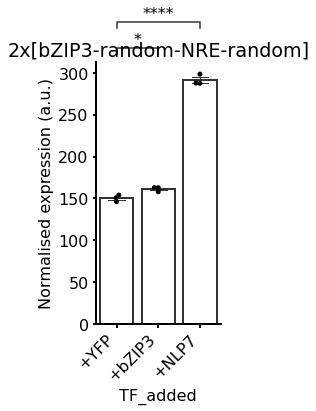

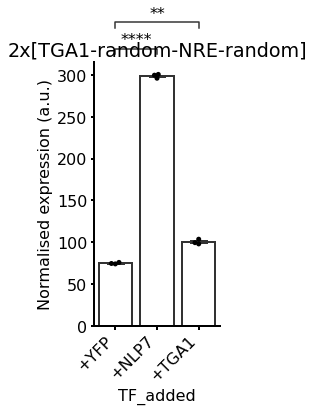

In [88]:
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
rcParams['font.size'] = 16
for prom in prom_names_plate1:
    if prom == 'NOS' or prom == 'STAP4':
        pass
    else:
        df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
        df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        df2['TF_added'] = 'pSTAP4 no TF'
        df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+No TF_1μM_NAA','+YFP','+YFP_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "+YFP":
                pass
            else:
                box_pairs.append(('+YFP',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))~
        box_pairs_all_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v
                

        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) < 3:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
            sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            #if no significant values, don't add stats annotation
            if len(box_pairs_significant.values()) < 1:
                pass
            else:
                add_stat_annotation(
                    fig,
                    data=df,
                    x='TF_added',
                    y='corrected_luminescence',
                    order=order,
                    box_pairs=list(box_pairs_significant.keys()),
                    text_format="star",
                    loc="outside",
                    verbose=2,
                    perform_stat_test=False,
                    pvalues=list(box_pairs_significant.values()),
                    #test_short_name="Dunn",
                )

            # change axes labels
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
                format="pdf",
                bbox_inches="tight",
            )
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

all pvalues={('+YFP', 'No TF'): 0.13152545106528946, ('+YFP', '+No TF_1μM_NAA'): 3.831198575691435e-05, ('+YFP', '+YFP_1μM_NAA'): 0.4169365129252954, ('+YFP', '+ANAC032'): 0.0008832483333750956, ('+YFP', '+ANR1'): 0.005775628600384588, ('+YFP', '+ARF18'): 0.0002576135007461478, ('+YFP', '+ARF9'): 8.41583905759486e-05, ('+YFP', '+bZIP3'): 7.588100974987696e-06, ('+YFP', '+DREB26'): 5.156165851163248e-05, ('+YFP', '+HHO2'): 0.003868765948785267, ('+YFP', '+NLP6'): 0.011115629729643318, ('+YFP', '+NLP7'): 0.00019644229173795038, ('+YFP', '+TGA1'): 1.888177497675754e-05}
NOS
['No TF', '+No TF_1μM_NAA', '+YFP', '+YFP_1μM_NAA', '+ANAC032', '+ANR1', '+ARF18', '+ARF9', '+bZIP3', '+DREB26', '+HHO2', '+NLP6', '+NLP7', '+TGA1']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+No TF_1μM_NAA v.s. +YFP: Custom statistical test, P_val:3.831e-05
+YFP v.s. +ANAC032: Custom statistical tes

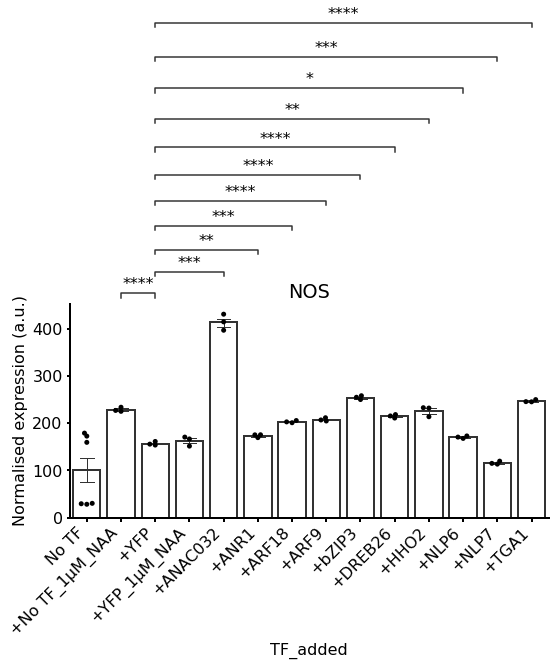

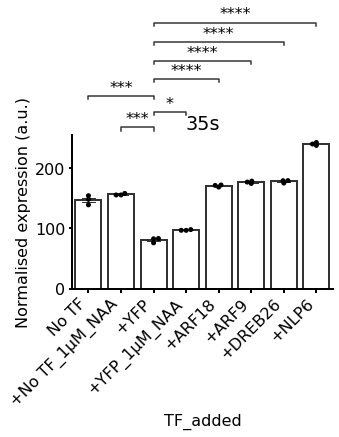

In [89]:
#layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
#make graphs for each promoter
#color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
#plots for promoters with more than 2 Tf categories
#prom == 'minimal_STAP4'
#set matplotlib default parameters
rcParams['xtick.major.width'] = 2
rcParams['ytick.major.width'] = 2
rcParams['axes.linewidth'] = 2
#rcParams['lines.linewidth'] = 2
#remove top and right lines
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
#font size
rcParams['font.size'] = 16
for prom in prom_names_plate2:
    if prom == 'STAP4':
        pass
    else:
        df1 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
        df2 = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
        #change name of TF added in df2 to minimal_stap4        
        df2['TF_added'] = 'pSTAP4 no TF'
        df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
        TFs_orig =  df.TF_added.unique()
        TF_order = ['No TF','+No TF_1μM_NAA','+YFP','+YFP_1μM_NAA','+ANAC032','+ANR1','+ARF18','+ARF18_1μM_NAA','+ARF9','+ARF9_1μM_NAA','+ARF18+ARF9','+ARF18+ARF9_1μM_NAA','+bZIP3','+DREB26','+HHO2','+NLP6','+NLP7','+TGA1']
        #sort based on custom order
        TFs = []
        for i in range(len(TF_order)):
            if TF_order[i] in TFs_orig:
                TFs+=[TF_order[i]]
        #print(df)
        #get length of number of TFs
        length_tf = len(TFs)
        #create order and box pairs based on the length of TFs
        order = []
        box_pairs = []   
        for x in range (0, (length_tf)):
            order.append(TFs[x])
            if TFs[x] == "+YFP":
                pass
            else:
                box_pairs.append(('+YFP',TFs[x]))
        #add every combination of box pairs of length 2
        #box_pairs=list(combinations(order, 2))
        box_pairs_all_pvalues = {}
        for pair in box_pairs:
            #create series objects
            TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
            TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
        # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
        # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
        #equal variance = false so do Welch's T-test
            results = stats.ttest_ind(TF1, TF2, equal_var=False)
            #append pvalue to dict
            box_pairs_all_pvalues[pair] = results.pvalue
        # box_pairs_significant.append(pair)
        # p_values.append(results.pvalue)
        print(f'all pvalues={box_pairs_all_pvalues}')

        # #filter dict by significance and put in a new dictionary
        box_pairs_significant = {}
        for k,v in box_pairs_all_pvalues.items():
            if v <0.05:
                box_pairs_significant[k] = v
                

        
        # if len(TFs) is 3:
        #     order = [TFs[0],TFs[1],TFs[2]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
        # elif len(TFs) is 4:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
        # elif len(TFs) is 5:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
        # elif len(TFs) is 6:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
        # elif len(TFs) is 7:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
        # elif len(TFs) is 8:
        #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
        #     # label box pairs
        #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


        if len(TFs) < 3:
            pass
        else:
            print(prom)
            print(TFs)
            plt.figure(figsize=((length_tf-(length_tf//2)+1),6))
            # fig = sns.catplot(
            #     x='TF_added',
            #     y='corrected_luminescence',
            #     data=df,
            #     kind='violin',
            #     order=order,            
            #     cut=0,
            #     legend=False,
            #     #color=new_color
            # )
            fig = sns.barplot(x='TF_added', y='corrected_luminescence', data=df, order=order, linewidth=2, facecolor=(1,1,1,1), errcolor=".2", edgecolor=".2", ci=68, errwidth=1,capsize=0.4)
            sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order,color='black')
            
            #fig = px.violin(df, x='TF_added',
            #                         y='corrected_luminescence', box=True,                       
            #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

            #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
            #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
            #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
            #hide legend
            #fig.layout.update(showlegend=False)
            # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
            # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
            # # label box pairs        
            # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
            # # make empty list of p_values
            # p_values = []
            # # populate the list of p_values according to the box_pairs
            # for pair in box_pairs:
            # #    print(pair)
            #     # select p value for each pair
            #     p = stat.loc[pair[0], pair[1]]
            #     p_values.append(p)

            # add stats annotation to the plot
            #if no significant values, don't add stats annotation
            if len(box_pairs_significant.values()) < 1:
                pass
            else:
                add_stat_annotation(
                    fig,
                    data=df,
                    x='TF_added',
                    y='corrected_luminescence',
                    order=order,
                    box_pairs=list(box_pairs_significant.keys()),
                    text_format="star",
                    loc="outside",
                    verbose=2,
                    perform_stat_test=False,
                    pvalues=list(box_pairs_significant.values()),
                    #test_short_name="Dunn",
                )

            # change axes labels
            plt.ylabel('Normalised expression (a.u.)')
            #add title
            plt.title(prom)
            #make xticks diagonal
            plt.xticks(rotation=45, ha='right')
            #plt.xlabel(x_label)
            # tight layout
            plt.tight_layout()
            # save figure
            plt.savefig(
                f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
                format="pdf",
                bbox_inches="tight",
            )
            


            #write to file static image and interactive one
        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
        #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
        #  fig.show()

minimal_STAP4
['+YFP']
4xNRE
['+YFP' '+NLP7']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+YFP v.s. +NLP7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.086e-02 U_stat=0.000e+00
4x[NRE-TATA]
['+YFP' '+NLP7']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+YFP v.s. +NLP7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.086e-02 U_stat=0.000e+00
4x[NRE-TATA]+spacing
['+YFP' '+NLP7']
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

+YFP v.s. +NLP7: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.086e-02 U_stat=0.000e+00
4x[NRE-random]
['+YFP' '+NLP7']
p-value annotatio

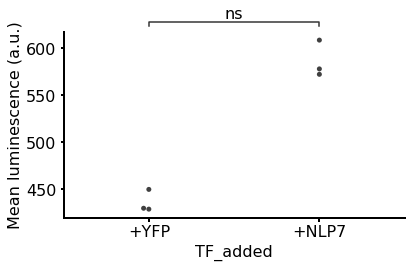

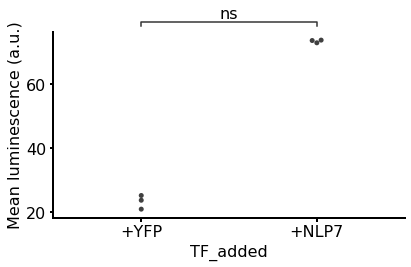

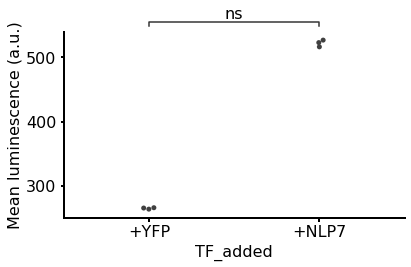

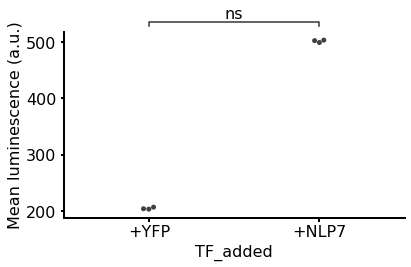

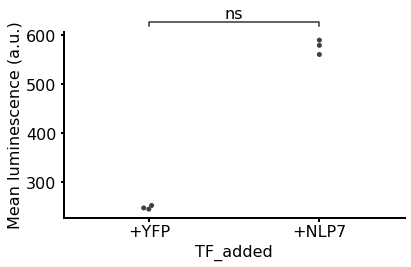

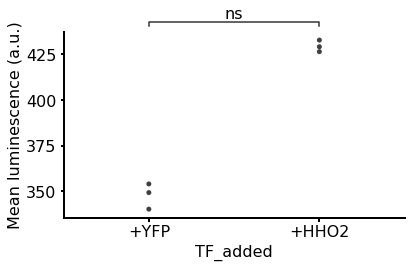

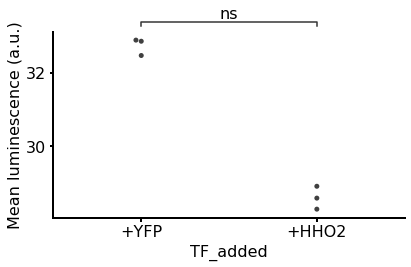

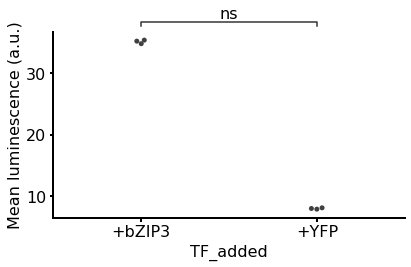

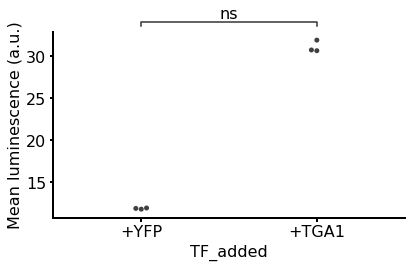

In [81]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

In [71]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters 2 Tf categories

# for prom in prom_names_plate2:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df = luminescence_raw_df_plate2[luminescence_raw_df_plate2.Promoter == prom].sort_values("TF_added", ascending=False)
#         TFs =  df.TF_added.unique()
#         print(prom)
#         print(TFs)
#         if len(TFs) is not 2:
#             pass
#         else:
#             plt.figure()
#             order = [TFs[0],TFs[1]]
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, color=".25", order=order)


#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
            
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             #stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # label box pairs        
#             box_pairs = [(TFs[0],TFs[1])]
#             # make empty list of p_values
#             p_values = []
#             # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             #     print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)

#             # add stats annotation to the plot
#             add_stat_annotation(
#                 fig,
#                 data=df,
#                 x='TF_added',
#                 y='corrected_luminescence',
#                 order=order,
#                 box_pairs=box_pairs,
#                 text_format="star",
#                 loc="outside",
#                 verbose=2,
#                 #perform_stat_test=False,
#                 #pvalues=p_values,
#                 test='Mann-Whitney',
#             )
#             # change axes labels
#             plt.ylabel('Mean luminescence (a.u.)')
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
            
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate2.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )           


#         #write to file static image and interactive one
#        # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#       #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#       #  fig.show()

35s
['No TF' '+YFP_1μM_NAA' '+YFP' '+No TF_1μM_NAA' '+NLP6' '+DREB26' '+ARF9'
 '+ARF18']


all pvalues={('No TF', '+YFP'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+NLP7'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+NLP7'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+NLP7'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+NLP7'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+NLP7'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+HHO2'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+HHO2'): nan}
all pvalues={('No TF', '+bZIP3'): nan, ('No TF', '+YFP'): nan}
all pvalues={('No TF', '+bZIP3'): nan, ('No TF', '+YFP'): nan, ('No TF', '+NLP7+bZIP3'): nan, ('No TF', '+NLP7'): nan}
2x[bZIP3-random-NRE-random]
['+bZIP3' '+YFP' '+NLP7+bZIP3' '+NLP7']
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+TGA1'): nan}
all pvalues={('No TF', '+YFP'): nan, ('No TF', '+TGA1'): nan, ('No TF', '+NLP7+TGA1'): nan, ('No TF', '+NLP7'): nan}
2x[TGA1-random-NRE-random]
['+YFP' '+TGA1' '+NLP7+TGA1' '+NLP7']
all pvalues={}


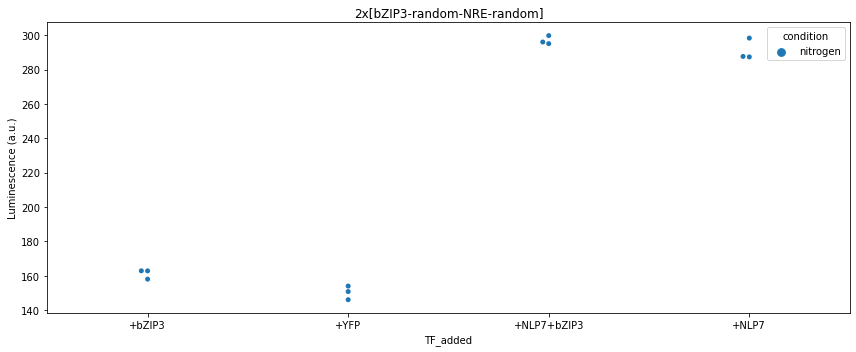

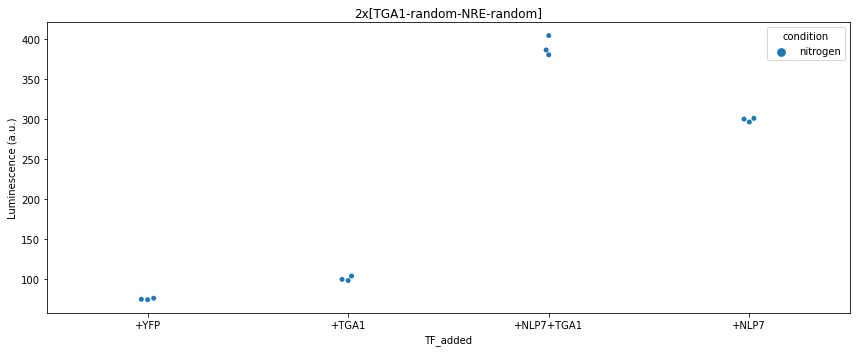

In [72]:
# #layout = go.Layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)' )
# #make graphs for each promoter
# #color_discrete_map = {'red': 'red', 'blue': 'blue', 'orange': 'orange', 'purple':'purple','green':'green','yellow':'yellow','brown':'brown','black':'black'}
# #plots for promoters with more than 2 Tf categories
# #prom == 'minimal_STAP4'
# for prom in prom_names_plate1:
#     if prom == 'NOS' or prom == 'STAP4':
#         pass
#     else:
#         df1 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == prom].sort_values("TF_added", ascending=False)
#         df2 = luminescence_raw_df_plate1[luminescence_raw_df_plate1.Promoter == 'STAP4'].sort_values("TF_added", ascending=False)
#         #change name of TF added in df2 to minimal_stap4        
#         df2['TF_added'] = 'pSTAP4 no TF'
#         df = pd.merge(df1,df2, how='outer').sort_values("TF_added", ascending=False)        
#         TFs =  df.TF_added.unique()
#         #print(df)
#         #get length of number of TFs
#         length_tf = len(TFs)
#         #create order and box pairs based on the length of TFs
#         order = []
#         box_pairs = []   
#         for x in range (0, (length_tf)):
#             order.append(TFs[x])
#             if TFs[x] == "No TF":
#                 pass
#             else:
#                 box_pairs.append(('No TF',TFs[x]))
#         #add every combination of box pairs of length 2
#         #box_pairs=list(combinations(order, 2))
#         box_pairs_all_pvalues = {}
#         for pair in box_pairs:
#             #create series objects
#             TF1 = df.query(f'TF_added == "{pair[0]}"')['corrected_luminescence']
#             TF2 = df.query(f'TF_added == "{pair[1]}"')['corrected_luminescence']
#         # probe1 = df.loc[df['probe'] == pair[0], corrected_luminescence]
#         # probe2 = df.loc[df['probe'] == pair[1], corrected_luminescence]
#         #equal variance = false so do Welch's T-test
#             results = stats.ttest_ind(TF1, TF2, equal_var=False)
#             #append pvalue to dict
#             box_pairs_all_pvalues[pair] = results.pvalue
#         # box_pairs_significant.append(pair)
#         # p_values.append(results.pvalue)
#         print(f'all pvalues={box_pairs_all_pvalues}')

#         # #filter dict by significance and put in a new dictionary
#         box_pairs_significant = {}
#         for k,v in box_pairs_all_pvalues.items():
#             if v <0.05:
#                 box_pairs_significant[k] = v
                

        
#         # if len(TFs) is 3:
#         #     order = [TFs[0],TFs[1],TFs[2]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[1],TFs[2])]
#         # elif len(TFs) is 4:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]),(TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]  
#         # elif len(TFs) is 5:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[3],TFs[4])]
#         # elif len(TFs) is 6:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[4],TFs[5])]
#         # elif len(TFs) is 7:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[5],TFs[6])]
#         # elif len(TFs) is 8:
#         #     order = [TFs[0],TFs[1],TFs[2],TFs[3],TFs[4],TFs[5],TFs[6],TFs[7]]
#         #     # label box pairs
#         #     box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]),(TFs[0],TFs[4]),(TFs[0],TFs[5]),(TFs[0],TFs[6]),(TFs[0],TFs[7]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[1],TFs[4]),(TFs[1],TFs[5]),(TFs[1],TFs[6]),(TFs[1],TFs[7]),(TFs[2],TFs[3]),(TFs[2],TFs[4]),(TFs[2],TFs[5]),(TFs[2],TFs[6]),(TFs[2],TFs[7]),(TFs[3],TFs[4]),(TFs[3],TFs[5]), (TFs[3],TFs[6]),(TFs[3],TFs[7]),(TFs[4],TFs[5]),(TFs[4],TFs[6]),(TFs[4],TFs[7]),(TFs[5],TFs[6]),(TFs[5],TFs[7]),(TFs[6],TFs[7])]
            


#         if len(TFs) < 3:
#             pass
#         else:
#             print(prom)
#             print(TFs)
#             plt.figure(figsize=((length_tf+8),5))
#             # fig = sns.catplot(
#             #     x='TF_added',
#             #     y='corrected_luminescence',
#             #     data=df,
#             #     kind='violin',
#             #     order=order,            
#             #     cut=0,
#             #     legend=False,
#             #     #color=new_color
#             # )
#             fig = sns.swarmplot(x='TF_added', y='corrected_luminescence', data=df, order=order, hue='condition')
#             #fig = px.violin(df, x='TF_added',
#             #                         y='corrected_luminescence', box=True,                       
#             #                      color='TF_added', color_discrete_map=new_color,violinmode='overlay',order=order) #points="all"

#             #fig.update_layout(plot_bgcolor='rgba(0,0,0,0)', paper_bgcolor='rgba(0,0,0,0)', title=prom,autosize=True)
#             #fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks="outside")
#             #fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks="outside", title_text='Mean luminescence (a.u.)')
#             #hide legend
#             #fig.layout.update(showlegend=False)
#             # add significance if necessary - dunn's posthocs with multiple Bonferroni correction
#             # stat = dunn_posthoc_test(df, 'corrected_luminescence', 'TF_added')
#             # # label box pairs        
#             # #box_pairs = [(TFs[0],TFs[1]), (TFs[0],TFs[2]),(TFs[0],TFs[3]), (TFs[1],TFs[2]),(TFs[1],TFs[3]),(TFs[2],TFs[3])]
#             # # make empty list of p_values
#             # p_values = []
#             # # populate the list of p_values according to the box_pairs
#             # for pair in box_pairs:
#             # #    print(pair)
#             #     # select p value for each pair
#             #     p = stat.loc[pair[0], pair[1]]
#             #     p_values.append(p)
#             #print("valuesSAM = " + str(box_pairs_significant.values()))
#             # add stats annotation to the plot
#             #if no significant values, don't add stats annotation
#             if len(box_pairs_significant.values()) < 1:
#                 pass
#             else:
#                 add_stat_annotation(
#                     fig,
#                     data=df,
#                     x='TF_added',
#                     y='corrected_luminescence',
#                     order=order,
#                     box_pairs=list(box_pairs_significant.keys()),
#                     text_format="star",
#                     loc="outside",
#                     verbose=2,
#                     perform_stat_test=False,
#                     pvalues=list(box_pairs_significant.values()),
#                     #test_short_name="Dunn",
#                 )
#             # change axes labels
#             plt.ylabel('Luminescence (a.u.)')
#             #add title
#             plt.title(prom)
#             #plt.xlabel(x_label)
#             # tight layout
#             plt.tight_layout()
#             # save figure
#             plt.savefig(
#                 f'../../../../data/plots/luminescence/{date}/scatter{prom}_plate1.pdf',
#                 format="pdf",
#                 bbox_inches="tight",
#             )
            


#             #write to file static image and interactive one
#         # fig.write_image(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.pdf', width=500, height=350, scale=5)
#         #  fig.write_html(f'../../../../data/plots/luminescence/{finaldate}/violin{prom}.html')
#         #  fig.show()

### test normality

In [73]:
#returns test statistic, p-value
for name1 in prom_names_plate1:
    for name in names_plate1:
        print(name1,'{}: {}'.format(name, stats.shapiro(luminescence_raw_df_plate1['nluc/fluc'][luminescence_raw_df_plate1.TF_added == name])))


NOS No TF: ShapiroResult(statistic=0.7083108425140381, pvalue=0.00755384610965848)
NOS +YFP: ShapiroResult(statistic=0.865602970123291, pvalue=0.00044452777365222573)
NOS +NLP7: ShapiroResult(statistic=0.8515490293502808, pvalue=0.0023359968326985836)
NOS +HHO2: ShapiroResult(statistic=0.6891829371452332, pvalue=0.004745053593069315)
NOS +bZIP3: ShapiroResult(statistic=0.6970699429512024, pvalue=0.0057565681636333466)
NOS +NLP7+bZIP3: ShapiroResult(statistic=0.8956851959228516, pvalue=0.37189507484436035)
NOS +TGA1: ShapiroResult(statistic=0.7194503545761108, pvalue=0.009845705702900887)
NOS +NLP7+TGA1: ShapiroResult(statistic=0.9247104525566101, pvalue=0.46914464235305786)
minimal_STAP4 No TF: ShapiroResult(statistic=0.7083108425140381, pvalue=0.00755384610965848)
minimal_STAP4 +YFP: ShapiroResult(statistic=0.865602970123291, pvalue=0.00044452777365222573)
minimal_STAP4 +NLP7: ShapiroResult(statistic=0.8515490293502808, pvalue=0.0023359968326985836)
minimal_STAP4 +HHO2: ShapiroResult(

#### not normal

In [77]:
#test variance
stats.levene(luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[0]], 
               luminescence_raw_df['nluc/fluc'][luminescence_raw_df.TF_added == names[1]])

LeveneResult(statistic=26.208483506980564, pvalue=2.2446306359947897e-06)

In [78]:
test = luminescence_raw_df.groupby('Promoter')

In [79]:
test

# one-way ANOVA: scipy.stats.kruskal

In [80]:
for name in names:
    print(name)

No TF
+ARF9
+HHO2
+ANR1
+bZIP3
+TGA1
+ARF18+ARF9
+ARF18
+ANAC032
+NLP7
+DREB26
+NLP6


In [81]:
#luminescence anova
for promoter, value in test:
    if promoter == 'ANAC032':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26+ARF18']))
    if promoter == 'ANR1':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'ARF18':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'NLP6':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
                value['corrected_luminescence'][value.TF_added == 'DREB26']))
    if promoter == 'DREB26':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],                
                value['corrected_luminescence'][value.TF_added == 'ARF18'],
               ))
    if promoter == 'NLP7':
        print(promoter)     
        print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'ANR1'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'ANAC032'],))
    
    if promoter == 'NIR1':
            
            print(promoter)     
            print(stats.f_oneway(value['corrected_luminescence'][value.TF_added == 'None'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7'],
                value['corrected_luminescence'][value.TF_added == 'NLP7'],                
                value['corrected_luminescence'][value.TF_added == 'DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6+NLP7+DREB26'],
                value['corrected_luminescence'][value.TF_added == 'NLP6']))        


ANAC032
F_onewayResult(statistic=nan, pvalue=nan)
ANR1
F_onewayResult(statistic=nan, pvalue=nan)
ARF18
F_onewayResult(statistic=nan, pvalue=nan)
DREB26
F_onewayResult(statistic=nan, pvalue=nan)
NIR1
F_onewayResult(statistic=nan, pvalue=nan)
NLP6
F_onewayResult(statistic=nan, pvalue=nan)
NLP7
F_onewayResult(statistic=nan, pvalue=nan)


/home/witham/opt/anaconda3/envs/PromoterArchitecturePipeline/lib/python3.7/site-packages/scipy/stats/stats.py:3612: F_onewayBadInputSizesWarning: at least one input has length 0
  warnings.warn(F_onewayBadInputSizesWarning('at least one input '


In [82]:
df = luminescence_raw_df
#First rerun NIR1 it as a GLM
NIR1 = df[df.Promoter == 'NIR1']  
results = ols('corrected_luminescence ~ C(TF_added)', data=NIR1).fit()
results.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                              
==================================================================================
Dep. Variable:     corrected_luminescence   R-squared:                       1.000
Model:                                OLS   Adj. R-squared:                  1.000
Method:                     Least Squares   F-statistic:                 1.865e+04
Date:                    Mon, 02 Aug 2021   Prob (F-statistic):           2.91e-59
Time:                            15:43:24   Log-Likelihood:                -32.491
No. Observations:                      45   AIC:                             88.98
Df Residuals:                          33   BIC:                             110.7
Df Model:                              11                                         
Covariance Type:                nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      6.7245      0.336     20.023      0.000       6.041       7.408
C(TF_added)[T.+ANR1]          -0.9453      0.475     -1.990      0.055      -1.912       0.021
C(TF_added)[T.+ARF18]         -5.5688      0.411    -13.539      0.000      -6.406      -4.732
C(TF_added)[T.+ARF18+ARF9]    -5.3439      0.411    -12.993      0.000      -6.181      -4.507
C(TF_added)[T.+ARF9]          -4.6423      0.411    -11.287      0.000      -5.479      -3.806
C(TF_added)[T.+DREB26]        -2.4859      0.475     -5.234      0.000      -3.452      -1.520
C(TF_added)[T.+HHO2]          -3.3290      0.475     -7.009      0.000      -4.295      -2.363
C(TF_added)[T.+NLP6]          51.5304      0.475    108.500      0.000      50.564      52.497
C(TF_added)[T.+NLP7]         148.5001      0.475    312.675      0.000     147.534     149.466
C(TF_added)[T.+TGA1]           2.2719      0.475      4.784      0.000       1.306       3.238
C(TF_added)[T.+bZIP3]          0.7928      0.475      1.669      0.105      -0.173       1.759
C(TF_added)[T.No TF]          -2.3599      0.475     -4.969      0.000      -3.326      -1.394
==============================================================================
Omnibus:                       52.636   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              560.059
Skew:                           2.459   Prob(JB):                    2.43e-122
Kurtosis:                      19.568   Cond. No.                         14.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [83]:
# #make anova table for NIR1
# aov_table = sm.stats.anova_lm(results, typ=2)
# aov_table

In [84]:
# #pairwise tukey posthoc test for NIR1

    
# mc = MultiComparison(NIR1['corrected_luminescence'], NIR1['TF_added'])
# mc_results = mc.tukeyhsd()
# print(mc_results)

In [85]:
rp.summary_cont(NIR1['corrected_luminescence'].groupby(NIR1['TF_added']))

,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,6.724485,0.023889,0.013793,6.691376,6.757594
+ANR1,3,5.779182,0.026019,0.015022,5.743122,5.815242
+ARF18,6,1.155667,0.057076,0.023301,1.105638,1.205697
+ARF18+ARF9,6,1.380576,0.151005,0.061647,1.248215,1.512937
+ARF9,6,2.082164,0.081723,0.033363,2.010530,2.153797
+DREB26,3,4.238549,0.044260,0.025553,4.177208,4.299890
+HHO2,3,3.395499,0.054186,0.031284,3.320401,3.470596
+NLP6,3,58.254933,0.322122,0.185977,57.808494,58.701372
+NLP7,3,155.224614,2.281168,1.317033,152.063076,158.386152


In [86]:
ANR1 = df[df.Promoter == 'ANR1']
rp.summary_cont(ANR1['corrected_luminescence'].groupby(ANR1['TF_added']))


,N,Mean,SD,SE,95% Conf.,Interval
TF_added,,,,,,
+ANAC032,3,15.083662,0.344479,0.198885,14.606239,15.561086
+ANR1,3,9.594051,0.196969,0.113720,9.321065,9.867036
+ARF18,6,3.382318,0.729296,0.297734,2.743062,4.021574
+ARF18+ARF9,6,3.770632,0.431280,0.176069,3.392599,4.148666
+ARF9,6,3.275840,0.127926,0.052225,3.163708,3.387972
+DREB26,3,19.188573,0.481732,0.278128,18.520927,19.856219
+HHO2,3,11.415834,0.268452,0.154991,11.043779,11.787889
+NLP6,3,10.353489,0.269201,0.155423,9.980396,10.726582
+NLP7,3,7.897732,0.168792,0.097452,7.663798,8.131666


In [87]:
for promoter, value in test:
    print('\033[1m' +promoter + '\033[0m')
    print(kruskal(data=df[df.Promoter == promoter], dv='corrected_luminescence', between='TF_added'))
    print('')

NOS
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

STAP4
           Source  ddof1    H  p-unc
Kruskal  TF_added      0  0.0    NaN

35s


ZeroDivisionError: division by zero

In [ ]:
#run Dunn's post-hoc test
#ANR1
sp.posthoc_dunn(df[df.Promoter == 'ANR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,ANR1,ARF18,DREB26,NLP7,None
ANR1,-1.000000,1.000000,0.071163,1.000000,1.000000
ARF18,1.000000,-1.000000,1.000000,0.454646,1.000000
DREB26,0.071163,1.000000,-1.000000,0.003175,1.000000
NLP7,1.000000,0.454646,0.003175,-1.000000,0.535796
None,1.000000,1.000000,1.000000,0.535796,-1.000000


In [ ]:
#NIR1 post-hoc test
sp.posthoc_dunn(df[df.Promoter == 'NIR1'], val_col='corrected_luminescence', group_col='TF_added', p_adjust='bonferroni')

,DREB26,NLP6,NLP6+NLP7,NLP6+NLP7+DREB26,NLP7,None
DREB26,-1.000000,0.537726,0.021630,0.052771,0.017535,1.000000
NLP6,0.537726,-1.000000,1.000000,1.000000,1.000000,1.000000
NLP6+NLP7,0.021630,1.000000,-1.000000,1.000000,1.000000,0.070083
NLP6+NLP7+DREB26,0.052771,1.000000,1.000000,-1.000000,1.000000,0.206551
NLP7,0.017535,1.000000,1.000000,1.000000,-1.000000,0.094729
None,1.000000,1.000000,0.070083,0.206551,0.094729,-1.000000
